Features

enrollee_id : Unique ID for candidate

city: City code

city_ development _index : Developement index of the city (scaled)

gender: Gender of candidate

relevent_experience: Relevant experience of candidate

enrolled_university: Type of University course enrolled if any

education_level: Education level of candidate

major_discipline :Education major discipline of candidate

experience: Candidate total experience in years

company_size: No of employees in current employer's company

company_type : Type of current employer

lastnewjob: Difference in years between previous job and current job

training_hours: training hours completed

target: 0 – Not looking for job change, 1 – Looking for a job change

Inspiration
Predict the probability of a candidate will work for the company
Interpret model(s) such a way that illustrate which features affect candidate decision
Please refer to the following task for more details:
https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists/tasks?taskId=3015

In [1]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore")        
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
import squarify
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 200

In [2]:
aug_train = pd.read_csv('aug_train.csv')
aug_test = pd.read_csv('aug_test.csv')
aug_train.head()


,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [3]:
aug_train.isna().sum()/len(aug_train)


enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

In [4]:


aug_train['last_new_job'] = aug_train['last_new_job'].apply(lambda x: 'Never' if x == 'never' else x) #just reads nicer
aug_train['enrolled_university'][aug_train['enrolled_university'] == 'no_enrollment'] = 'No Enrollment' #just reads nicer
aug_train['company_size'] = aug_train['company_size'].apply(lambda x: '10-49' if x == '10/49' else x) #diff replacement method

aug_train['experience'] = aug_train['experience'].apply(lambda x: '0' if x == '<1' else x)
aug_train['experience'] = aug_train['experience'].apply(lambda x: '20' if x == '>20' else x)


aug_train['company_size'].fillna('0',inplace=True)
aug_train['company_type'].fillna('Unknown',inplace=True)
aug_train['major_discipline'].fillna('Unknown',inplace=True)
aug_train['gender'].fillna('Not provided',inplace=True)



aug_test['last_new_job'] = aug_test['last_new_job'].apply(lambda x: 'Never' if x == 'never' else x) #just reads nicer
aug_test['enrolled_university'][aug_test['enrolled_university'] == 'no_enrollment'] = 'No Enrollment' #just reads nicer
aug_test['company_size'] = aug_test['company_size'].apply(lambda x: '10-49' if x == '10/49' else x) #diff replacement method

aug_test['experience'] = aug_test['experience'].apply(lambda x: '0' if x == '<1' else x)
aug_test['experience'] = aug_test['experience'].apply(lambda x: '20' if x == '>20' else x)

aug_test['company_size'].fillna('0',inplace=True)
aug_test['company_type'].fillna('Unknown',inplace=True)
aug_test['major_discipline'].fillna('Unknown',inplace=True)
aug_test['gender'].fillna('Not provided',inplace=True)




aug_train['target'].groupby(aug_train['gender']).mean()

gender
Female          0.263328
Male            0.227819
Not provided    0.308119
Other           0.261780
Name: target, dtype: float64

In [5]:
aug_train.dropna(inplace=True)
aug_test.dropna(inplace=True)
aug_train.isna().sum()/len(aug_train)

enrollee_id               0.0
city                      0.0
city_development_index    0.0
gender                    0.0
relevent_experience       0.0
enrolled_university       0.0
education_level           0.0
major_discipline          0.0
experience                0.0
company_size              0.0
company_type              0.0
last_new_job              0.0
training_hours            0.0
target                    0.0
dtype: float64

In [6]:
# Converting objects to integers

aug_train['experience'] = aug_train['experience'].astype(str).astype(int)
aug_test['experience'] = aug_test['experience'].astype(str).astype(int)

aug_train['training_hours'] = aug_train['training_hours'].astype(str).astype(int)
aug_test['training_hours'] = aug_test['training_hours'].astype(str).astype(int)


In [7]:
# Orders

ed_order = ['Primary School','High School','Graduate','Masters','Phd']
enroll_order = ['No Enrollment','Part time course','Full time course']
disc_order = ['STEM','Unknown','Humanities','Other','Business Degree','Arts','No Major']
exp_yrs_order = ['<1','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','>20']
exp_yrs_order_2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
size_order = ['0','<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
job_order = ['Never', '1', '2', '3', '4', '>4']
exp_order =['No relevant experience','Has relevant experience']
gender_order = ['Male','Female','Other','Not provided']
company_order = ['Pvt Ltd','Unknown','Funded Startup','Public Sector','Early Stage Startup','NGO','Other']
 
# for visuals
train_df = aug_train
test_df = aug_test


# Knowing more about the candidates using Data Visualization 

In [48]:
def plot_bar (column , title , order=None):
    x = aug_train[column].value_counts().index
    y = aug_train[column].value_counts().values
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.barplot(x, y, order=order).set_title(title)
def plot_pie (column , title):
    values = aug_train[column].value_counts().values
    labels = aug_train[column].value_counts().index
    plt.figure(figsize=(2,2))
    plt.title(title)
    plt.pie(x=values, labels=labels, autopct='%1.2f%%')

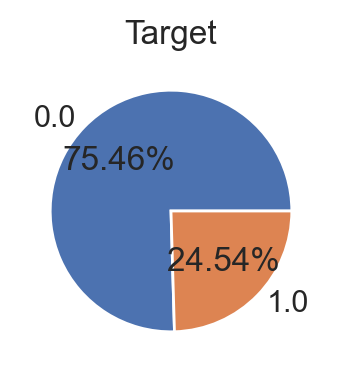

In [49]:
plot_pie ("target", 'Target')


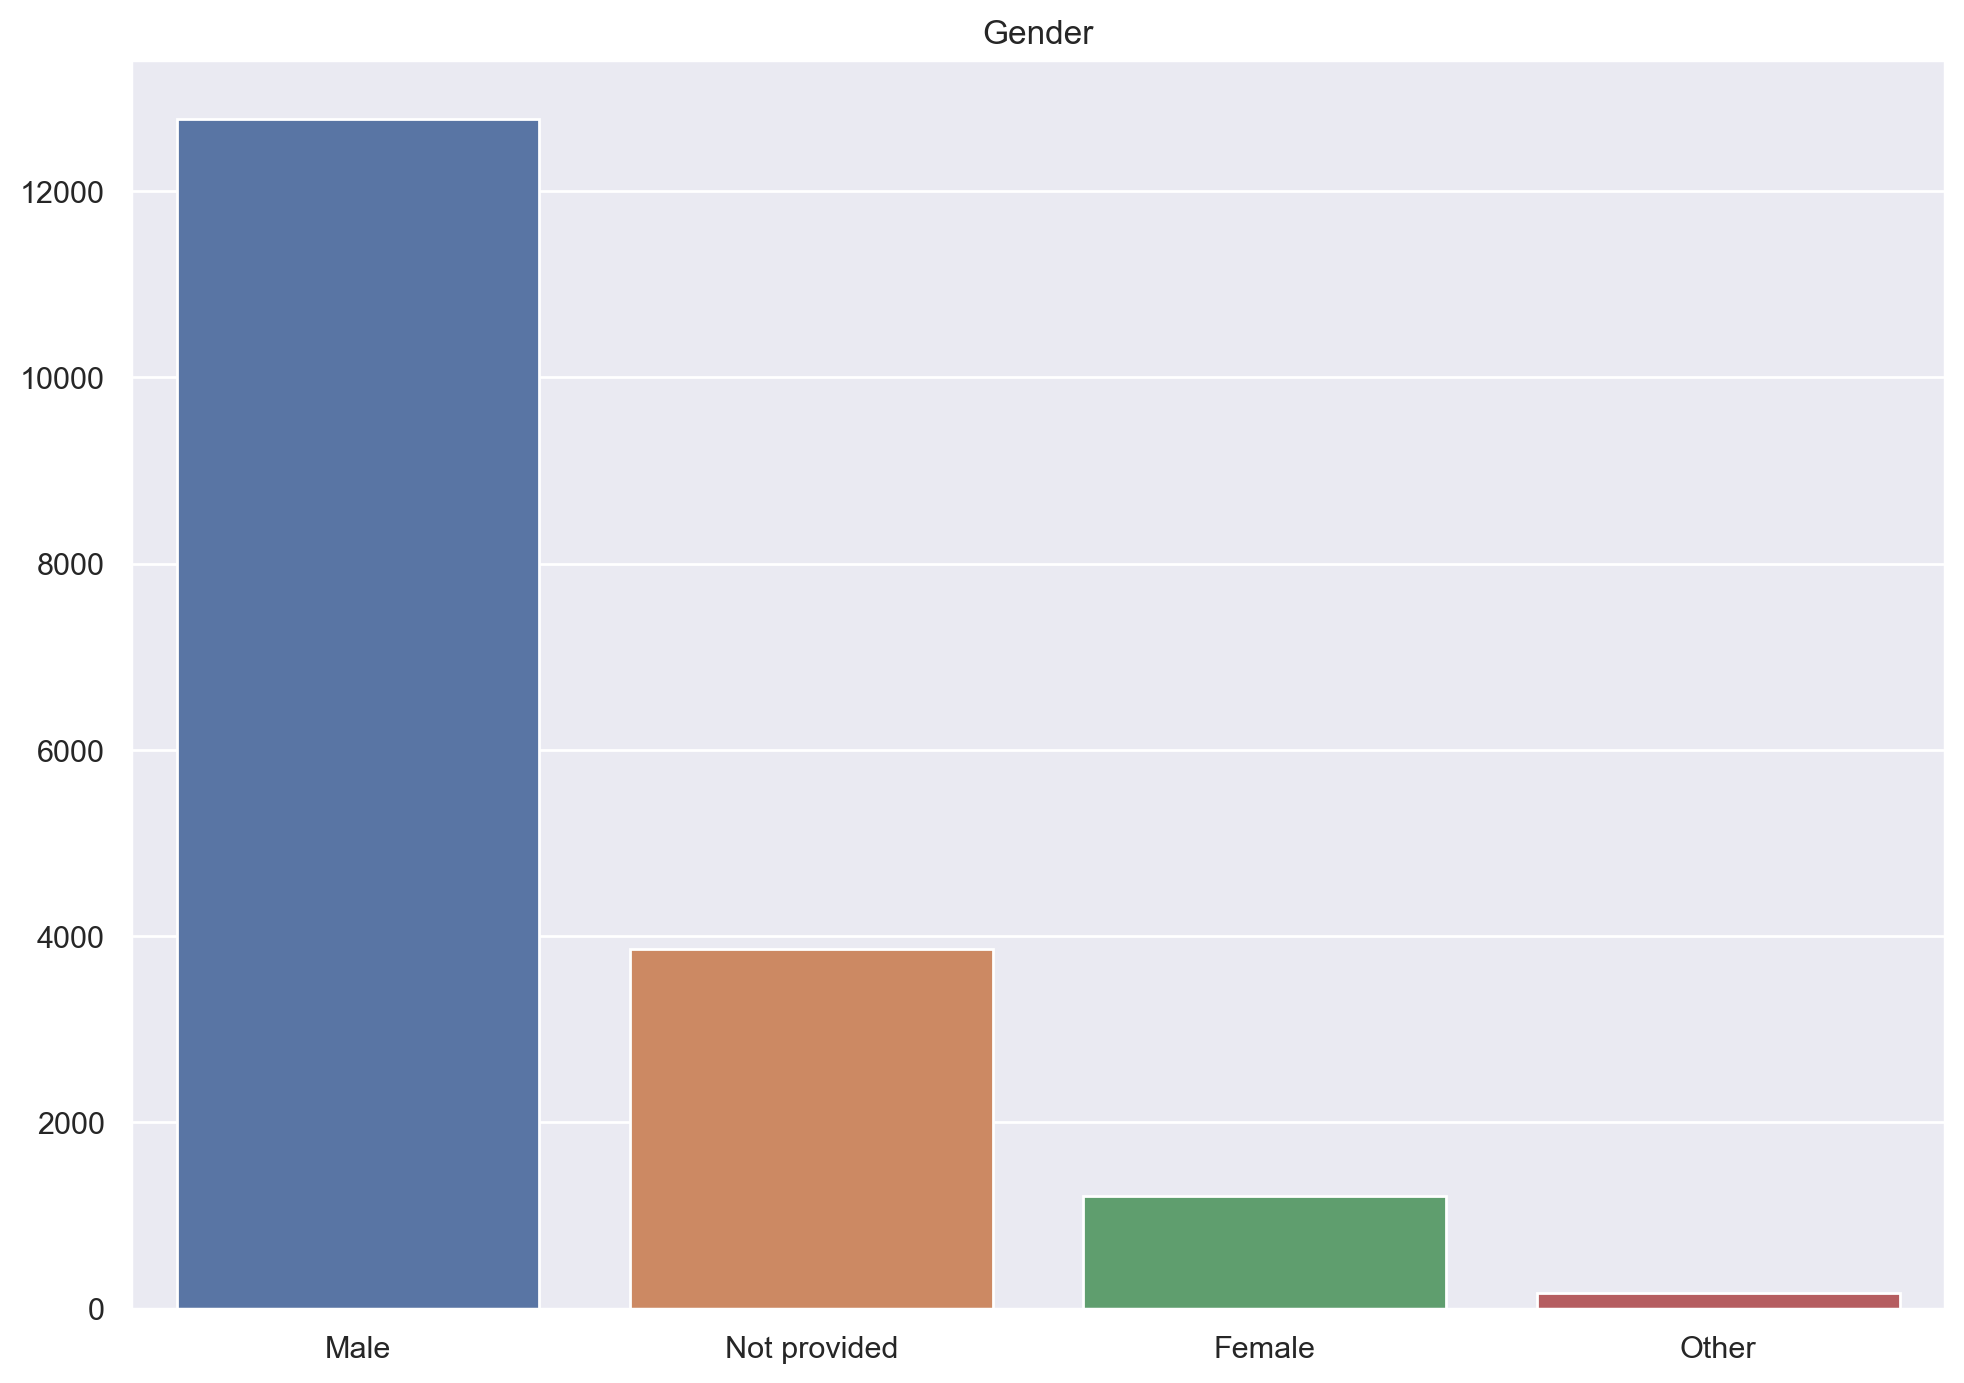

In [50]:
plot_bar ("gender", 'Gender')


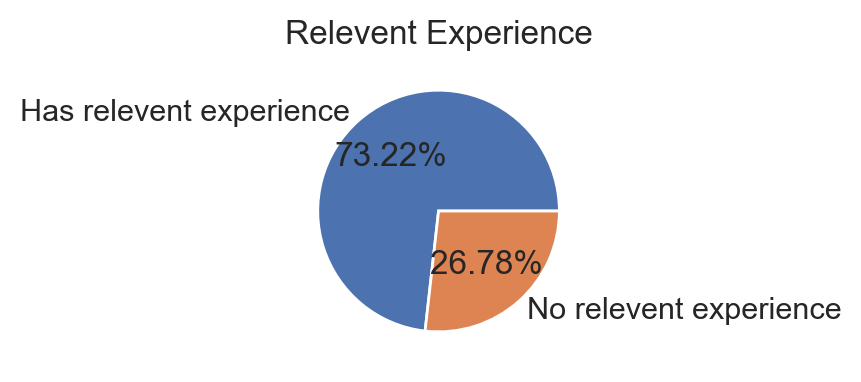

In [51]:
plot_pie ("relevent_experience",'Relevent Experience')


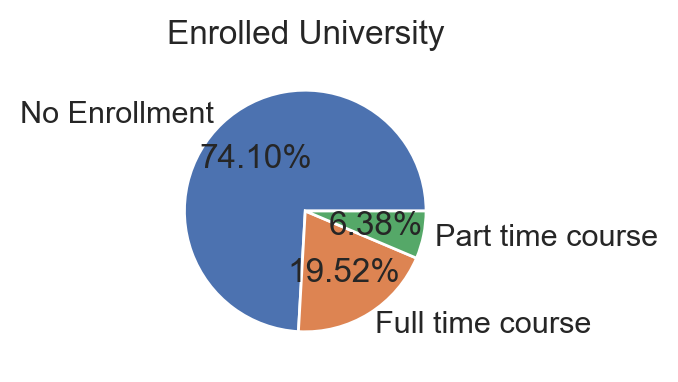

In [52]:
plot_pie ("enrolled_university", 'Enrolled University')


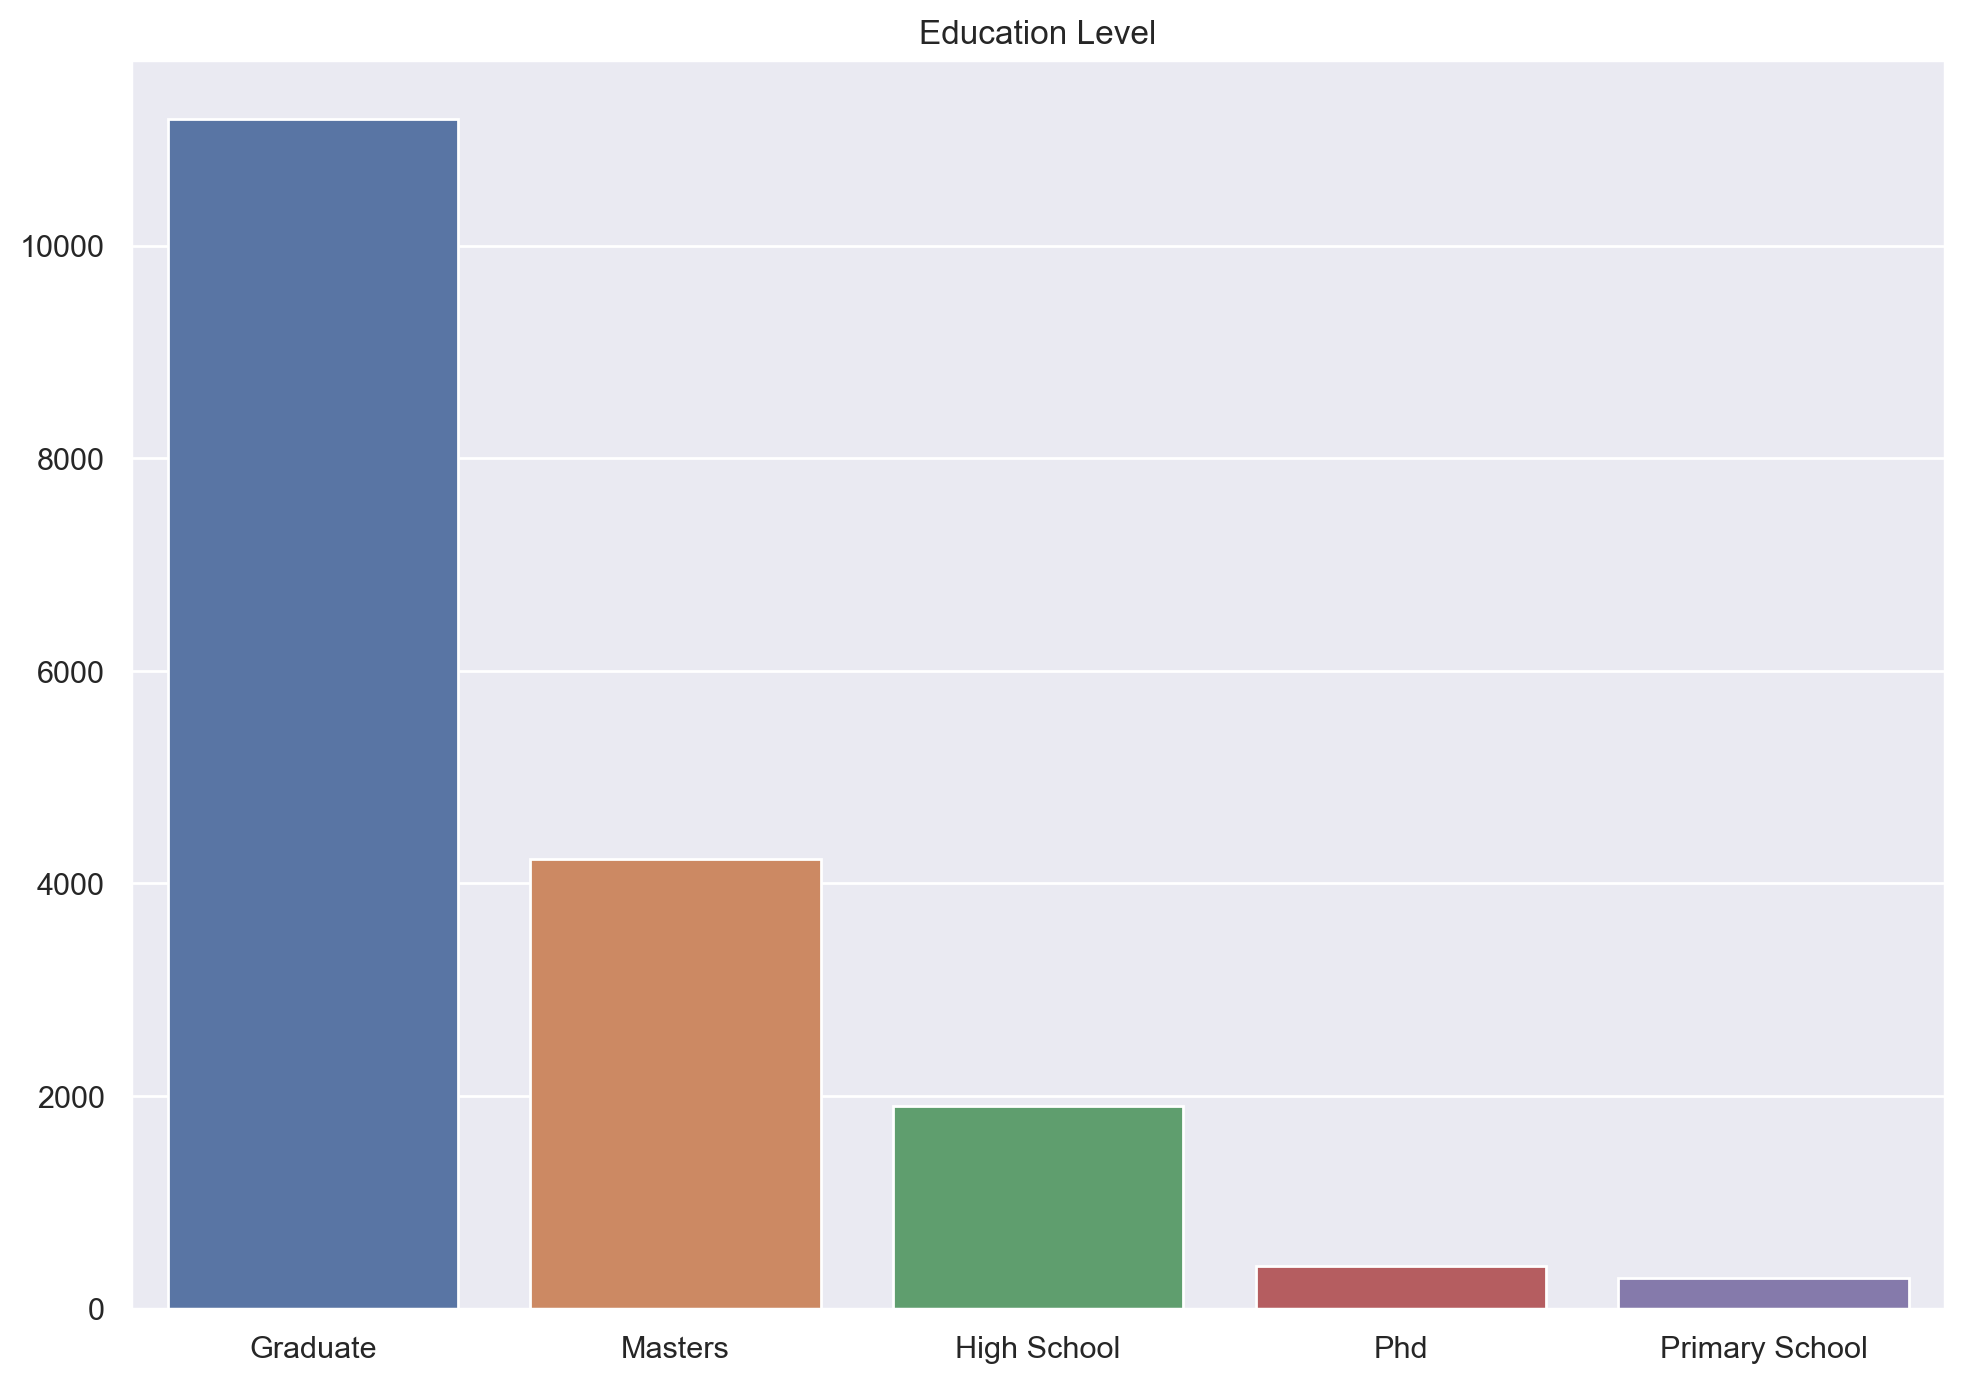

In [53]:
plot_bar ("education_level", 'Education Level')

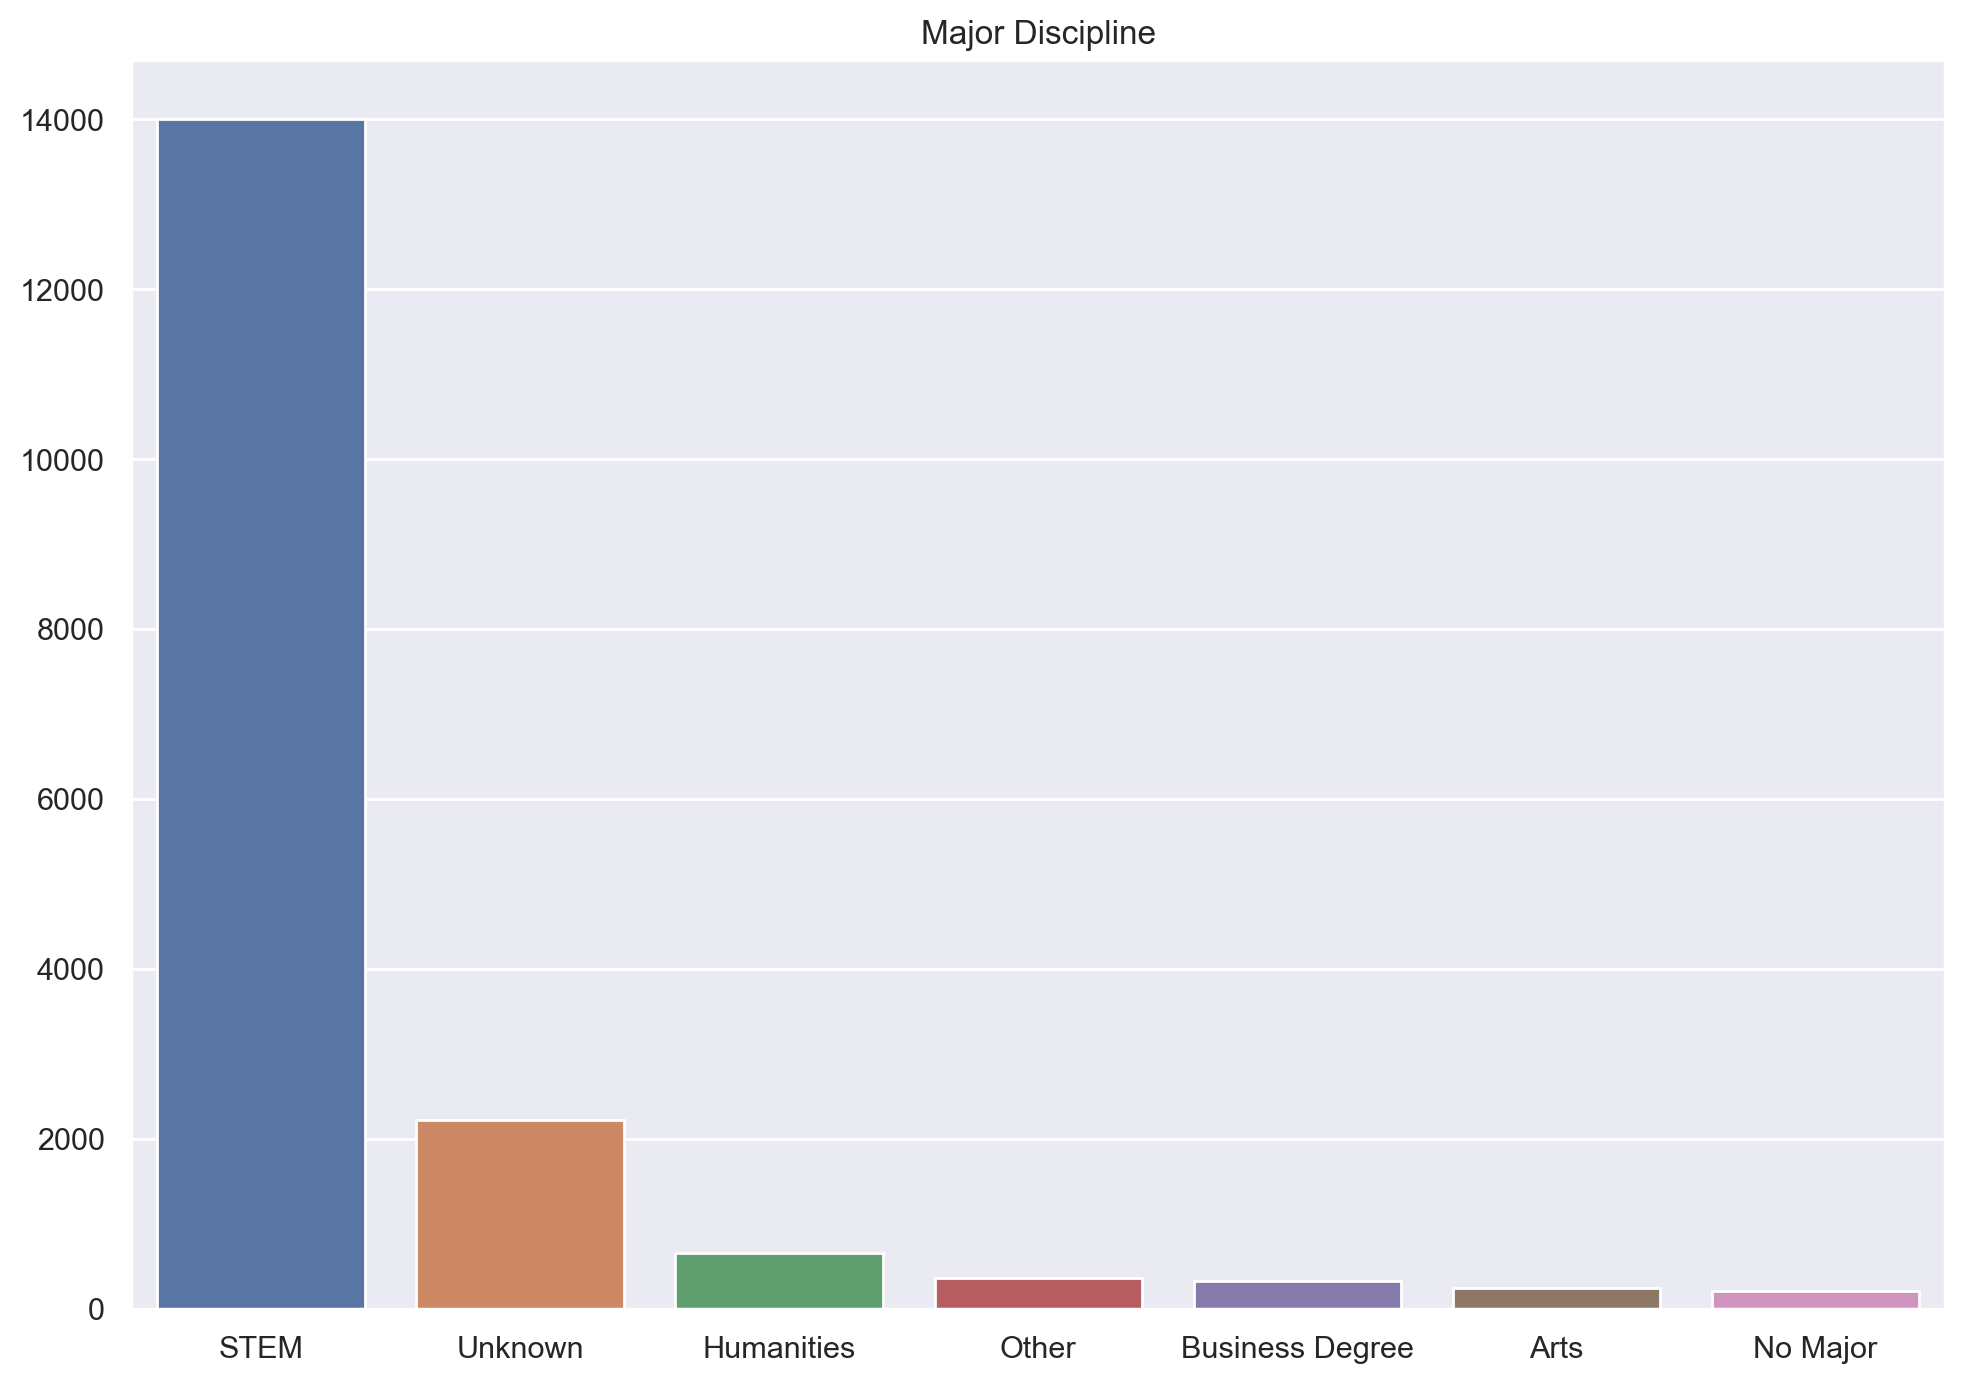

In [54]:
plot_bar ("major_discipline", "Major Discipline")

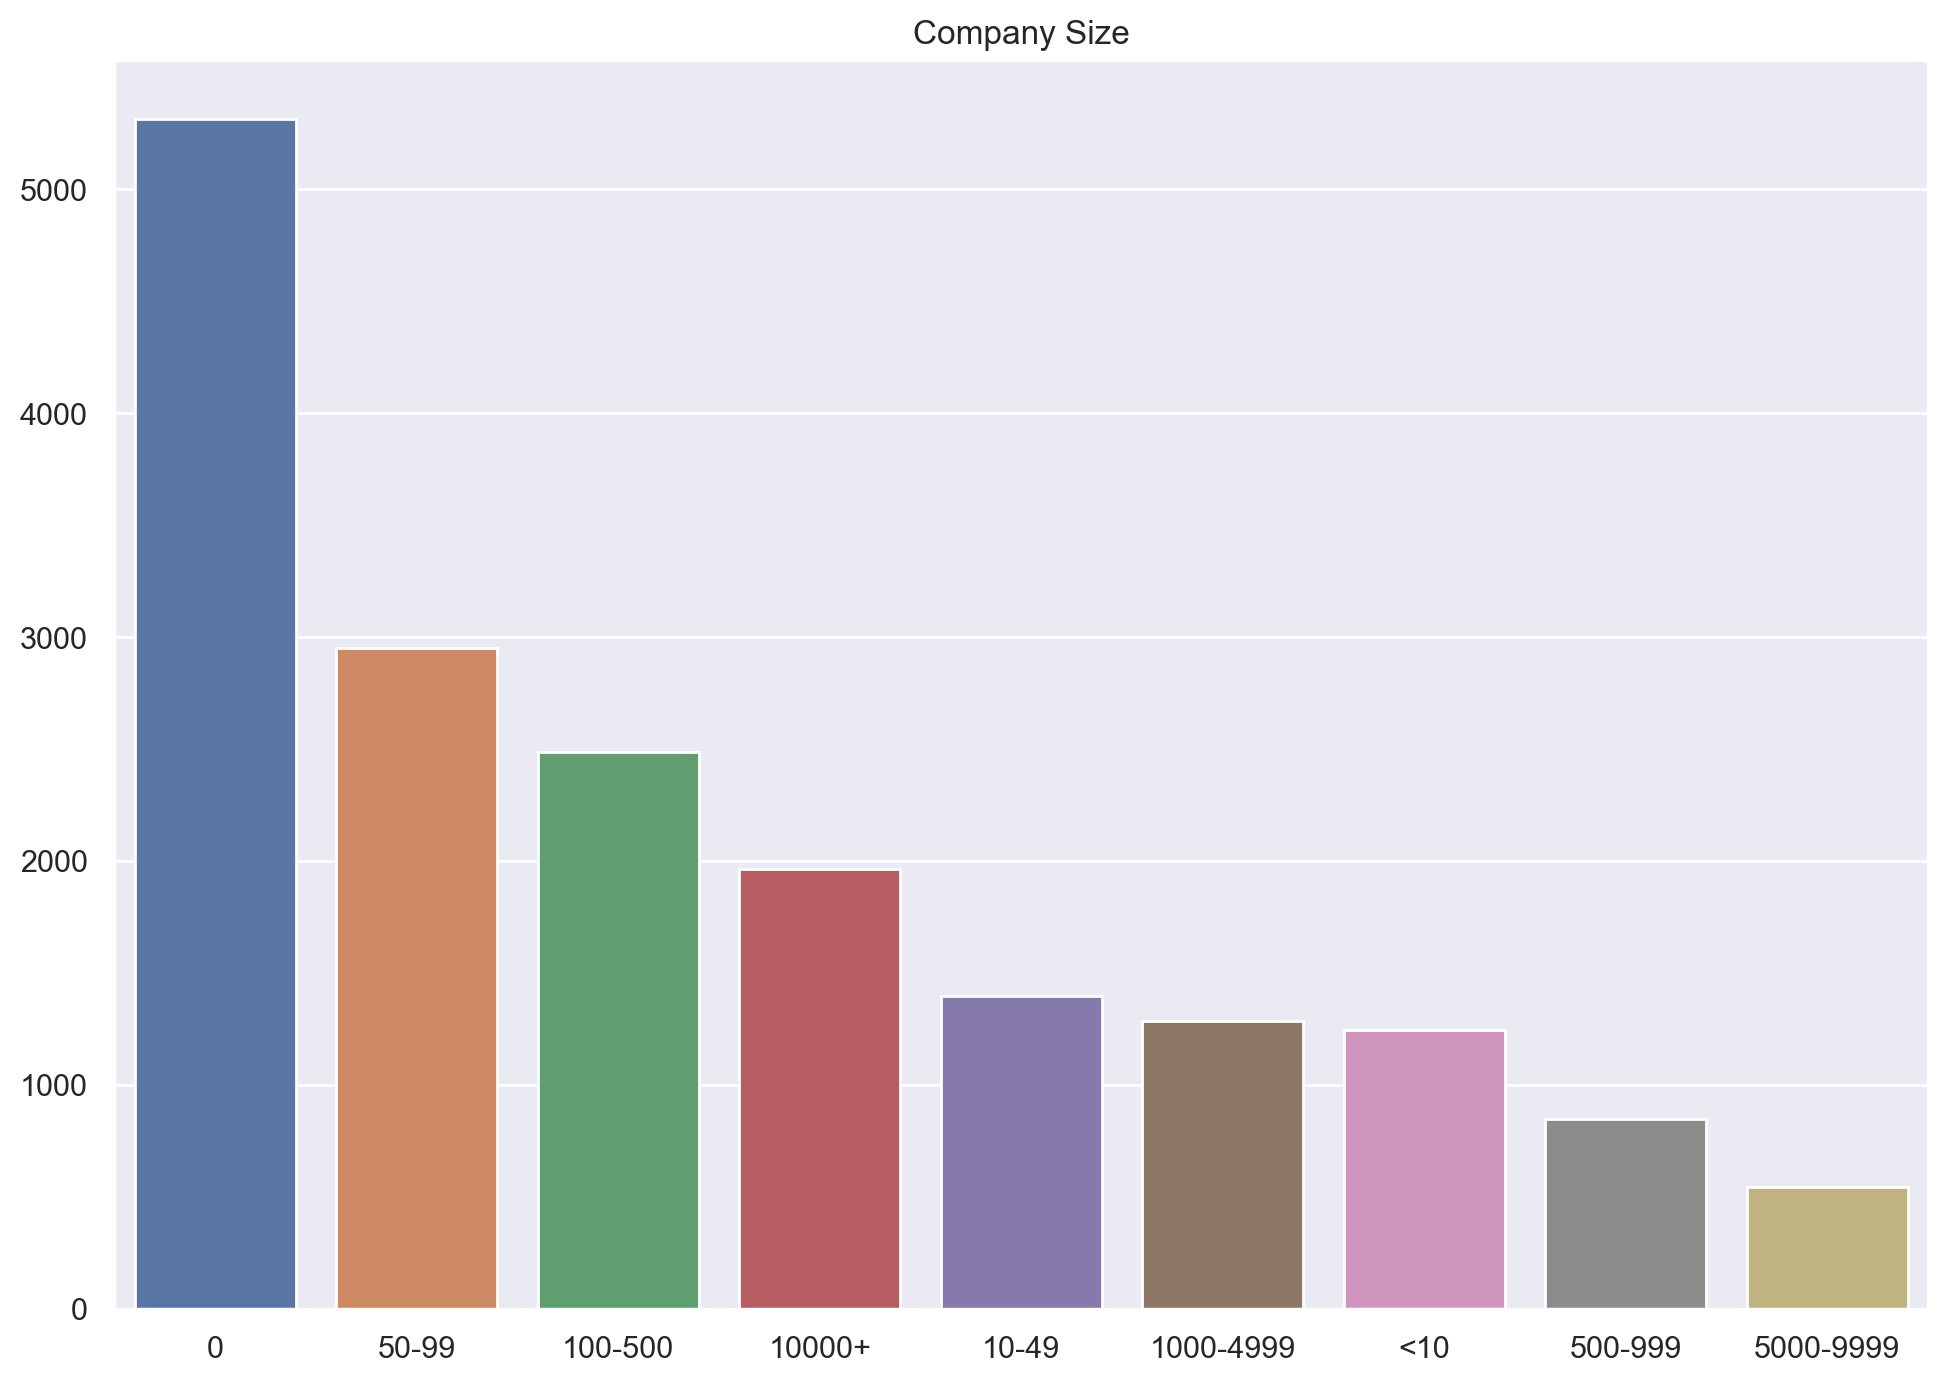

In [55]:
plot_bar ("company_size","Company Size")


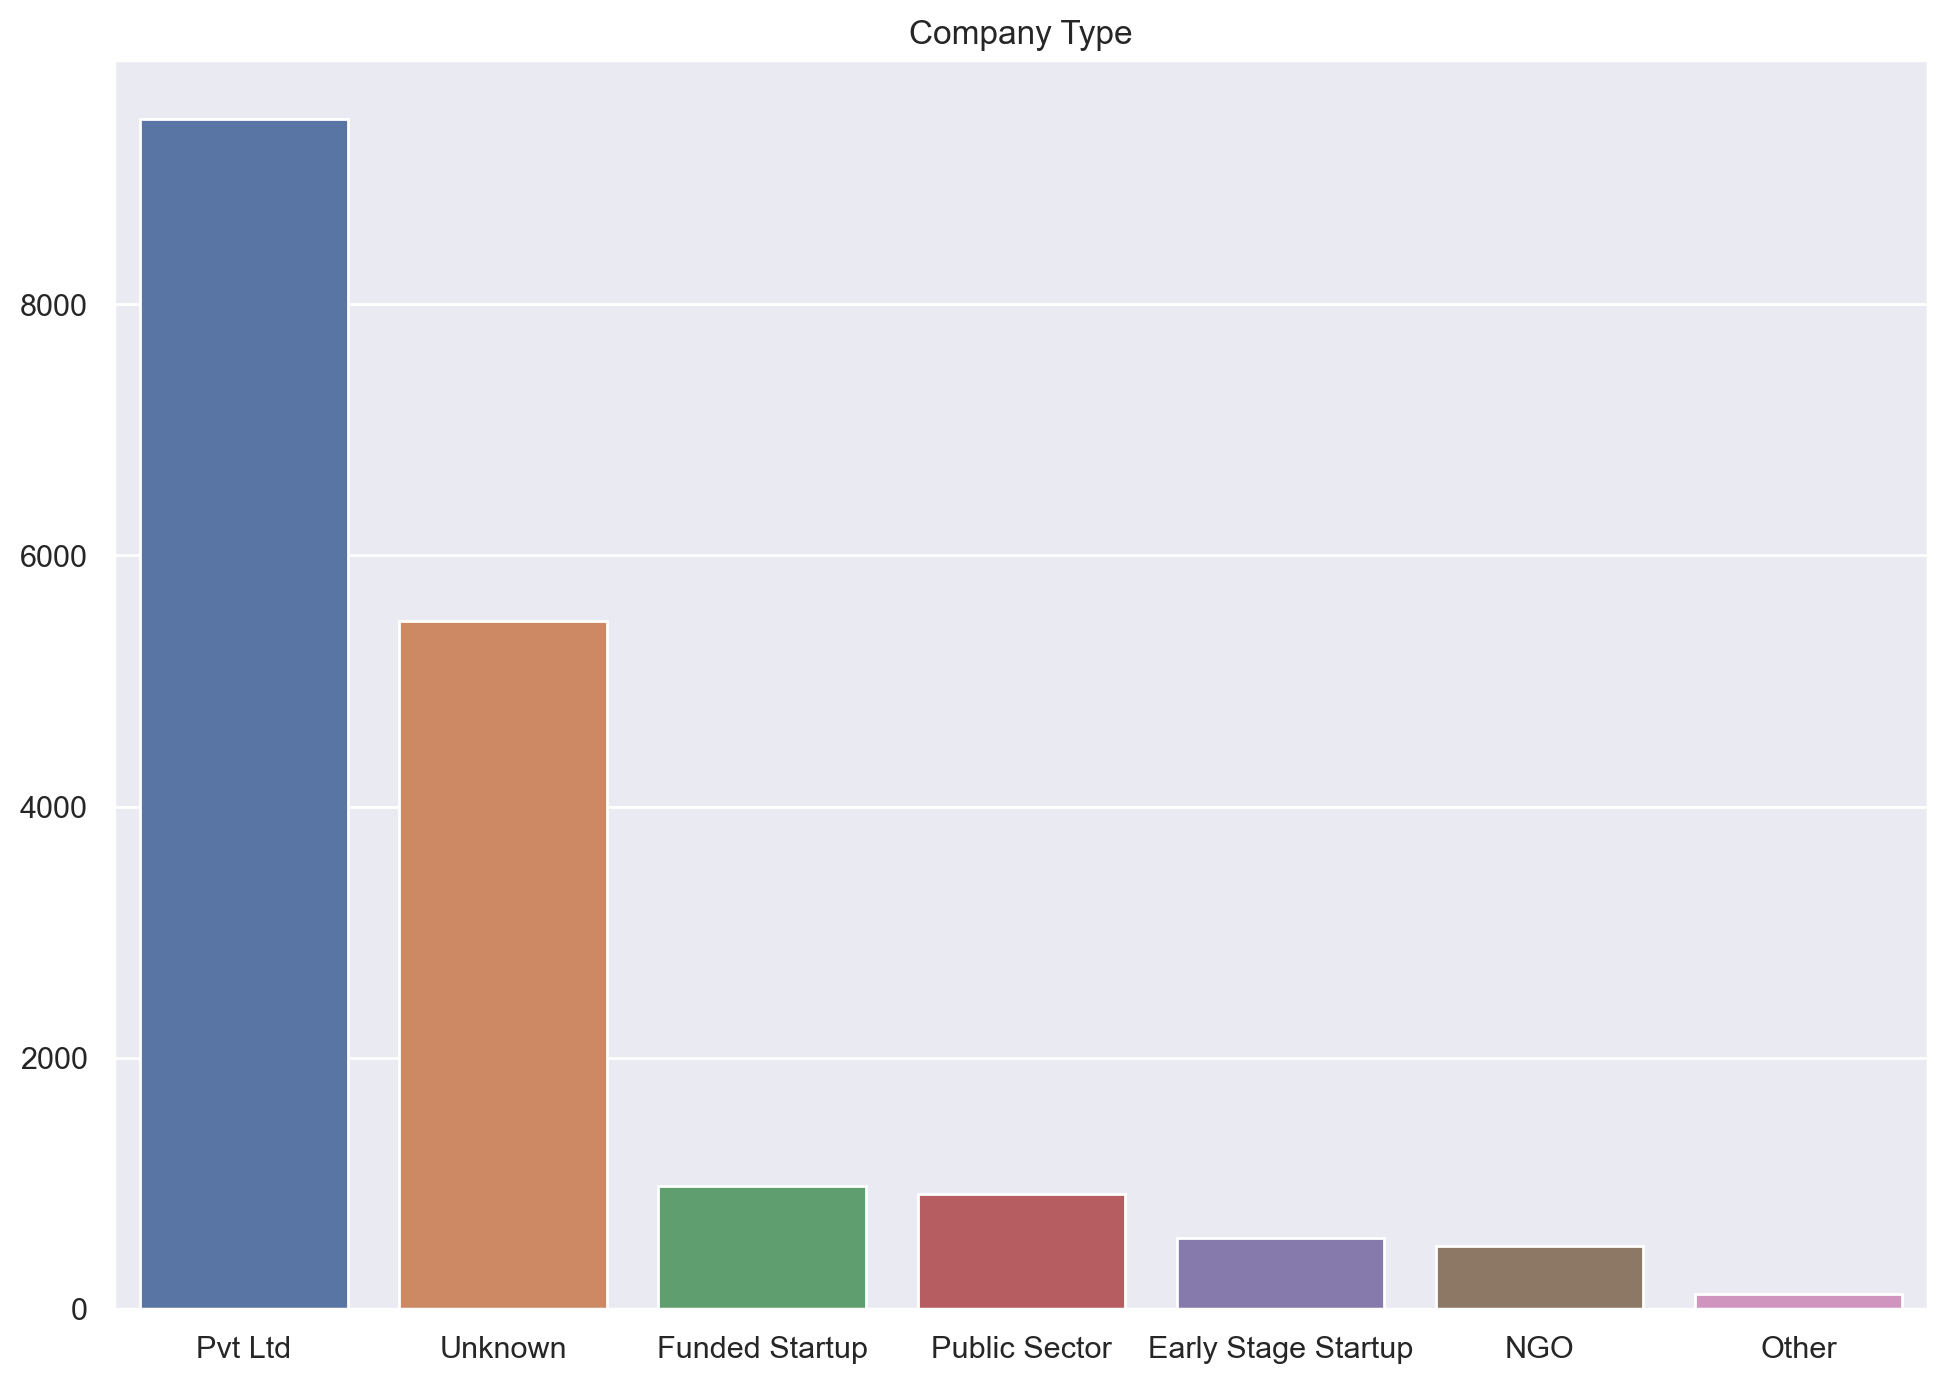

In [56]:
plot_bar ("company_type","Company Type")


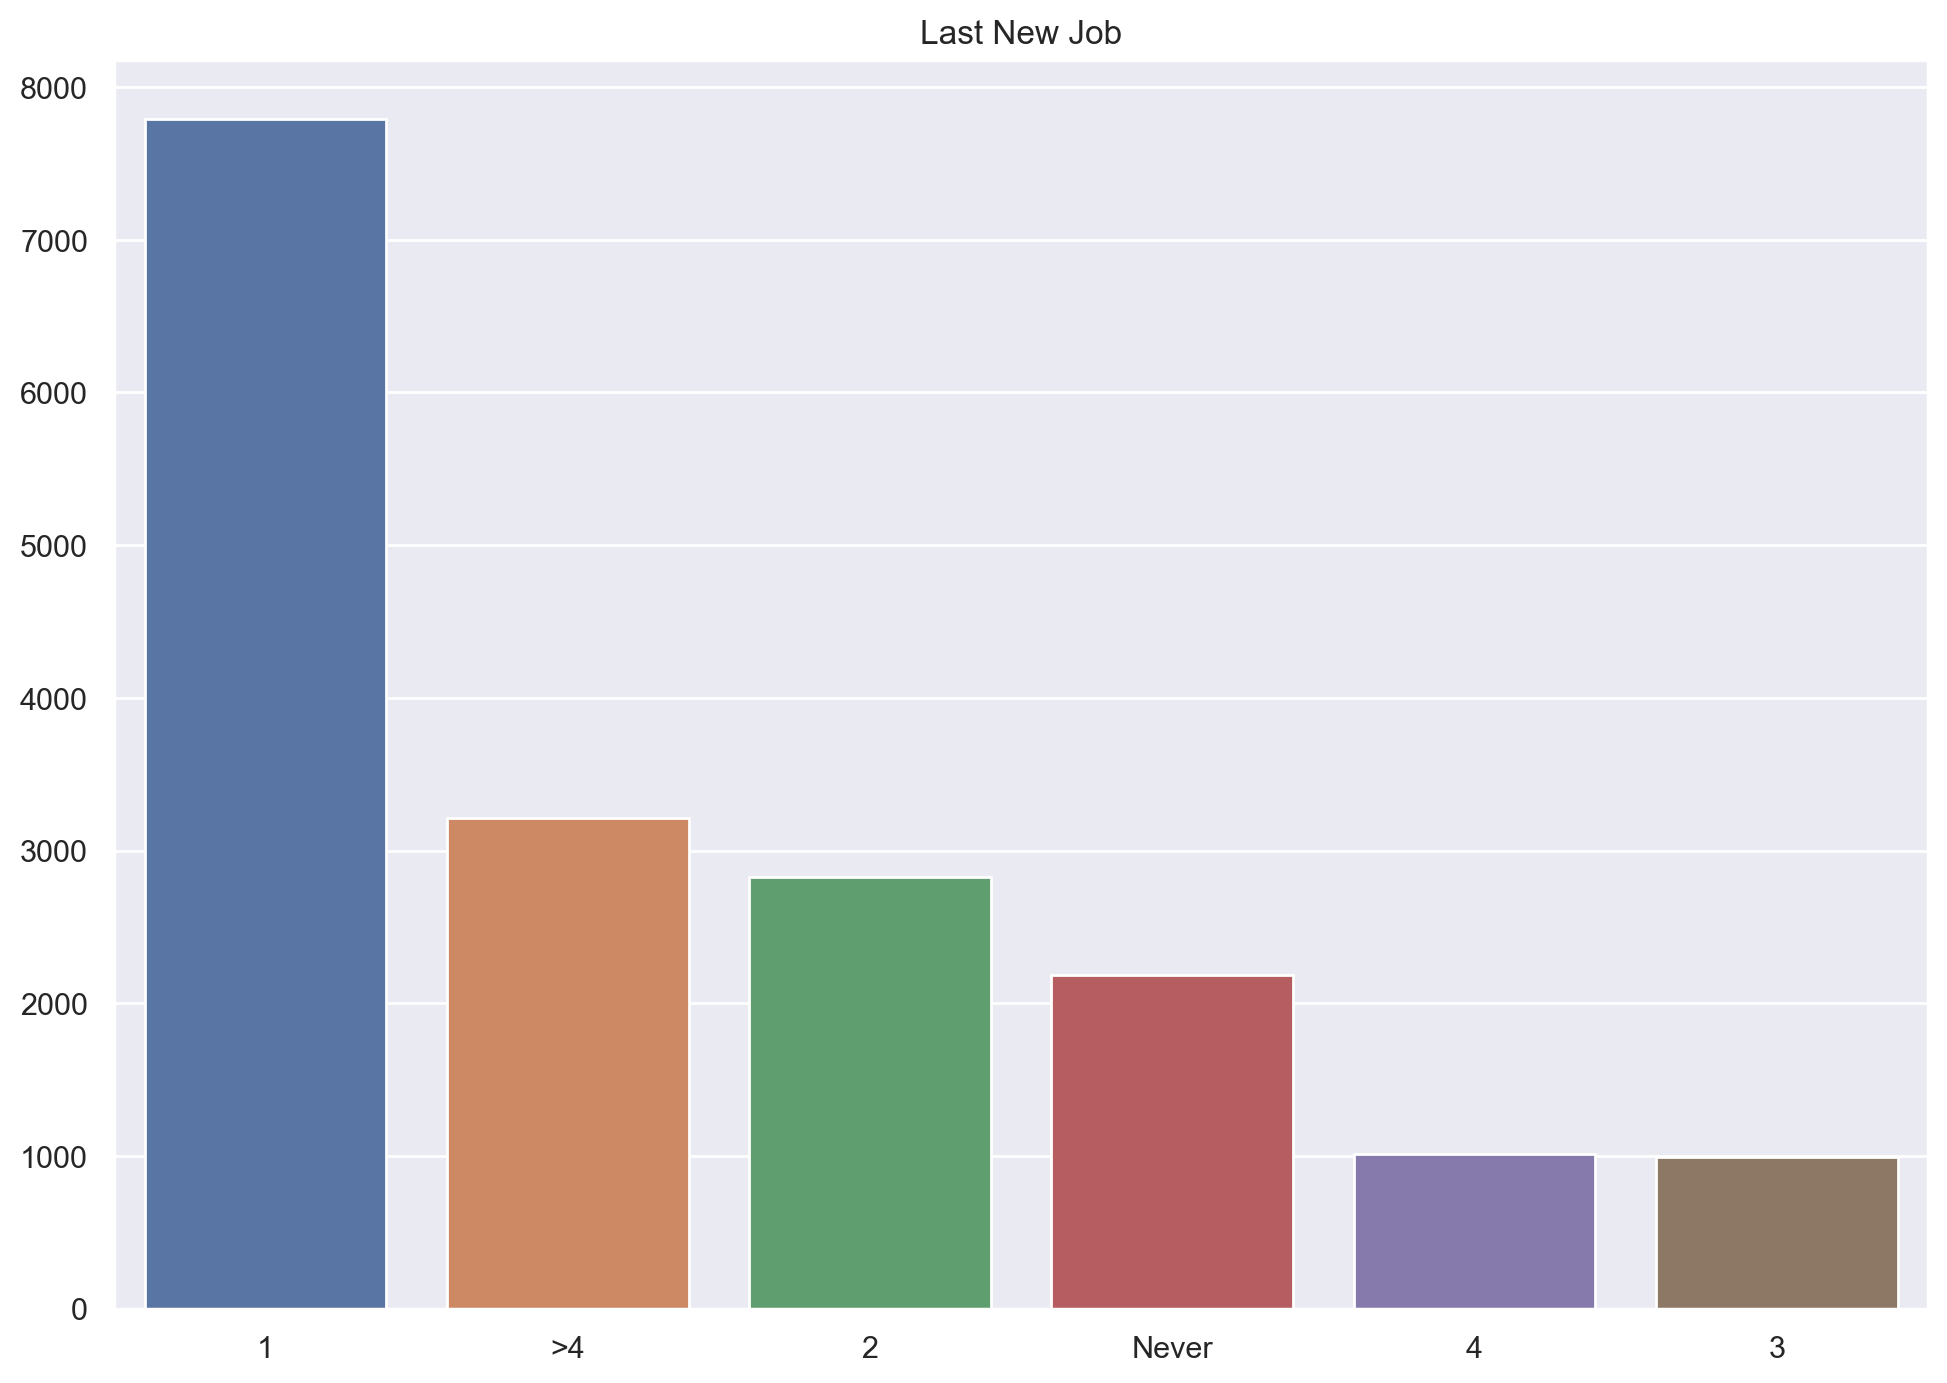

In [57]:
plot_bar ("last_new_job","Last New Job")


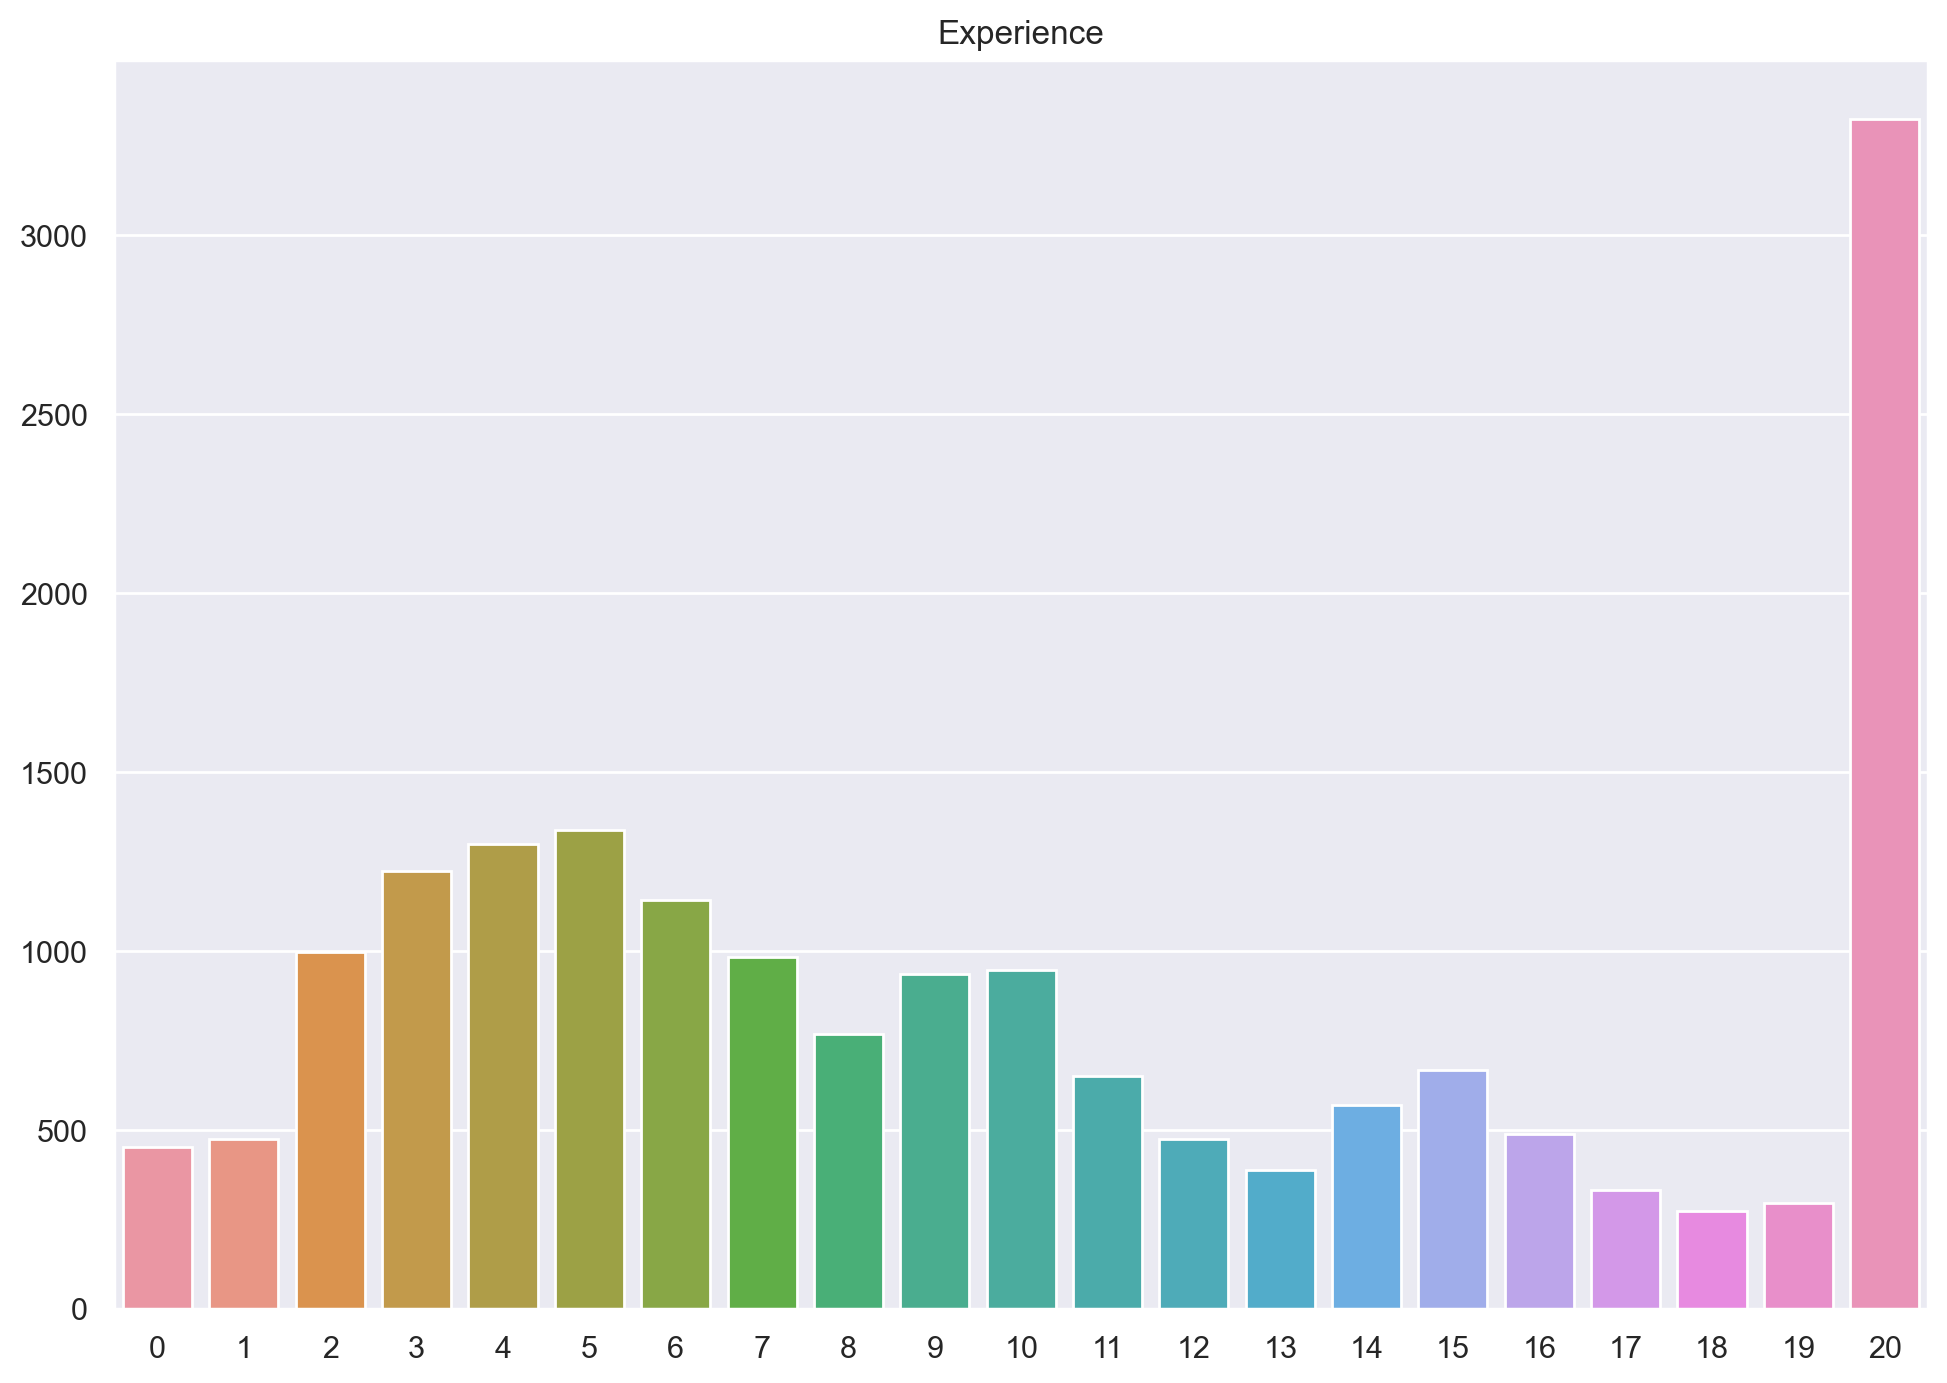

In [58]:
plot_bar ("experience","Experience")


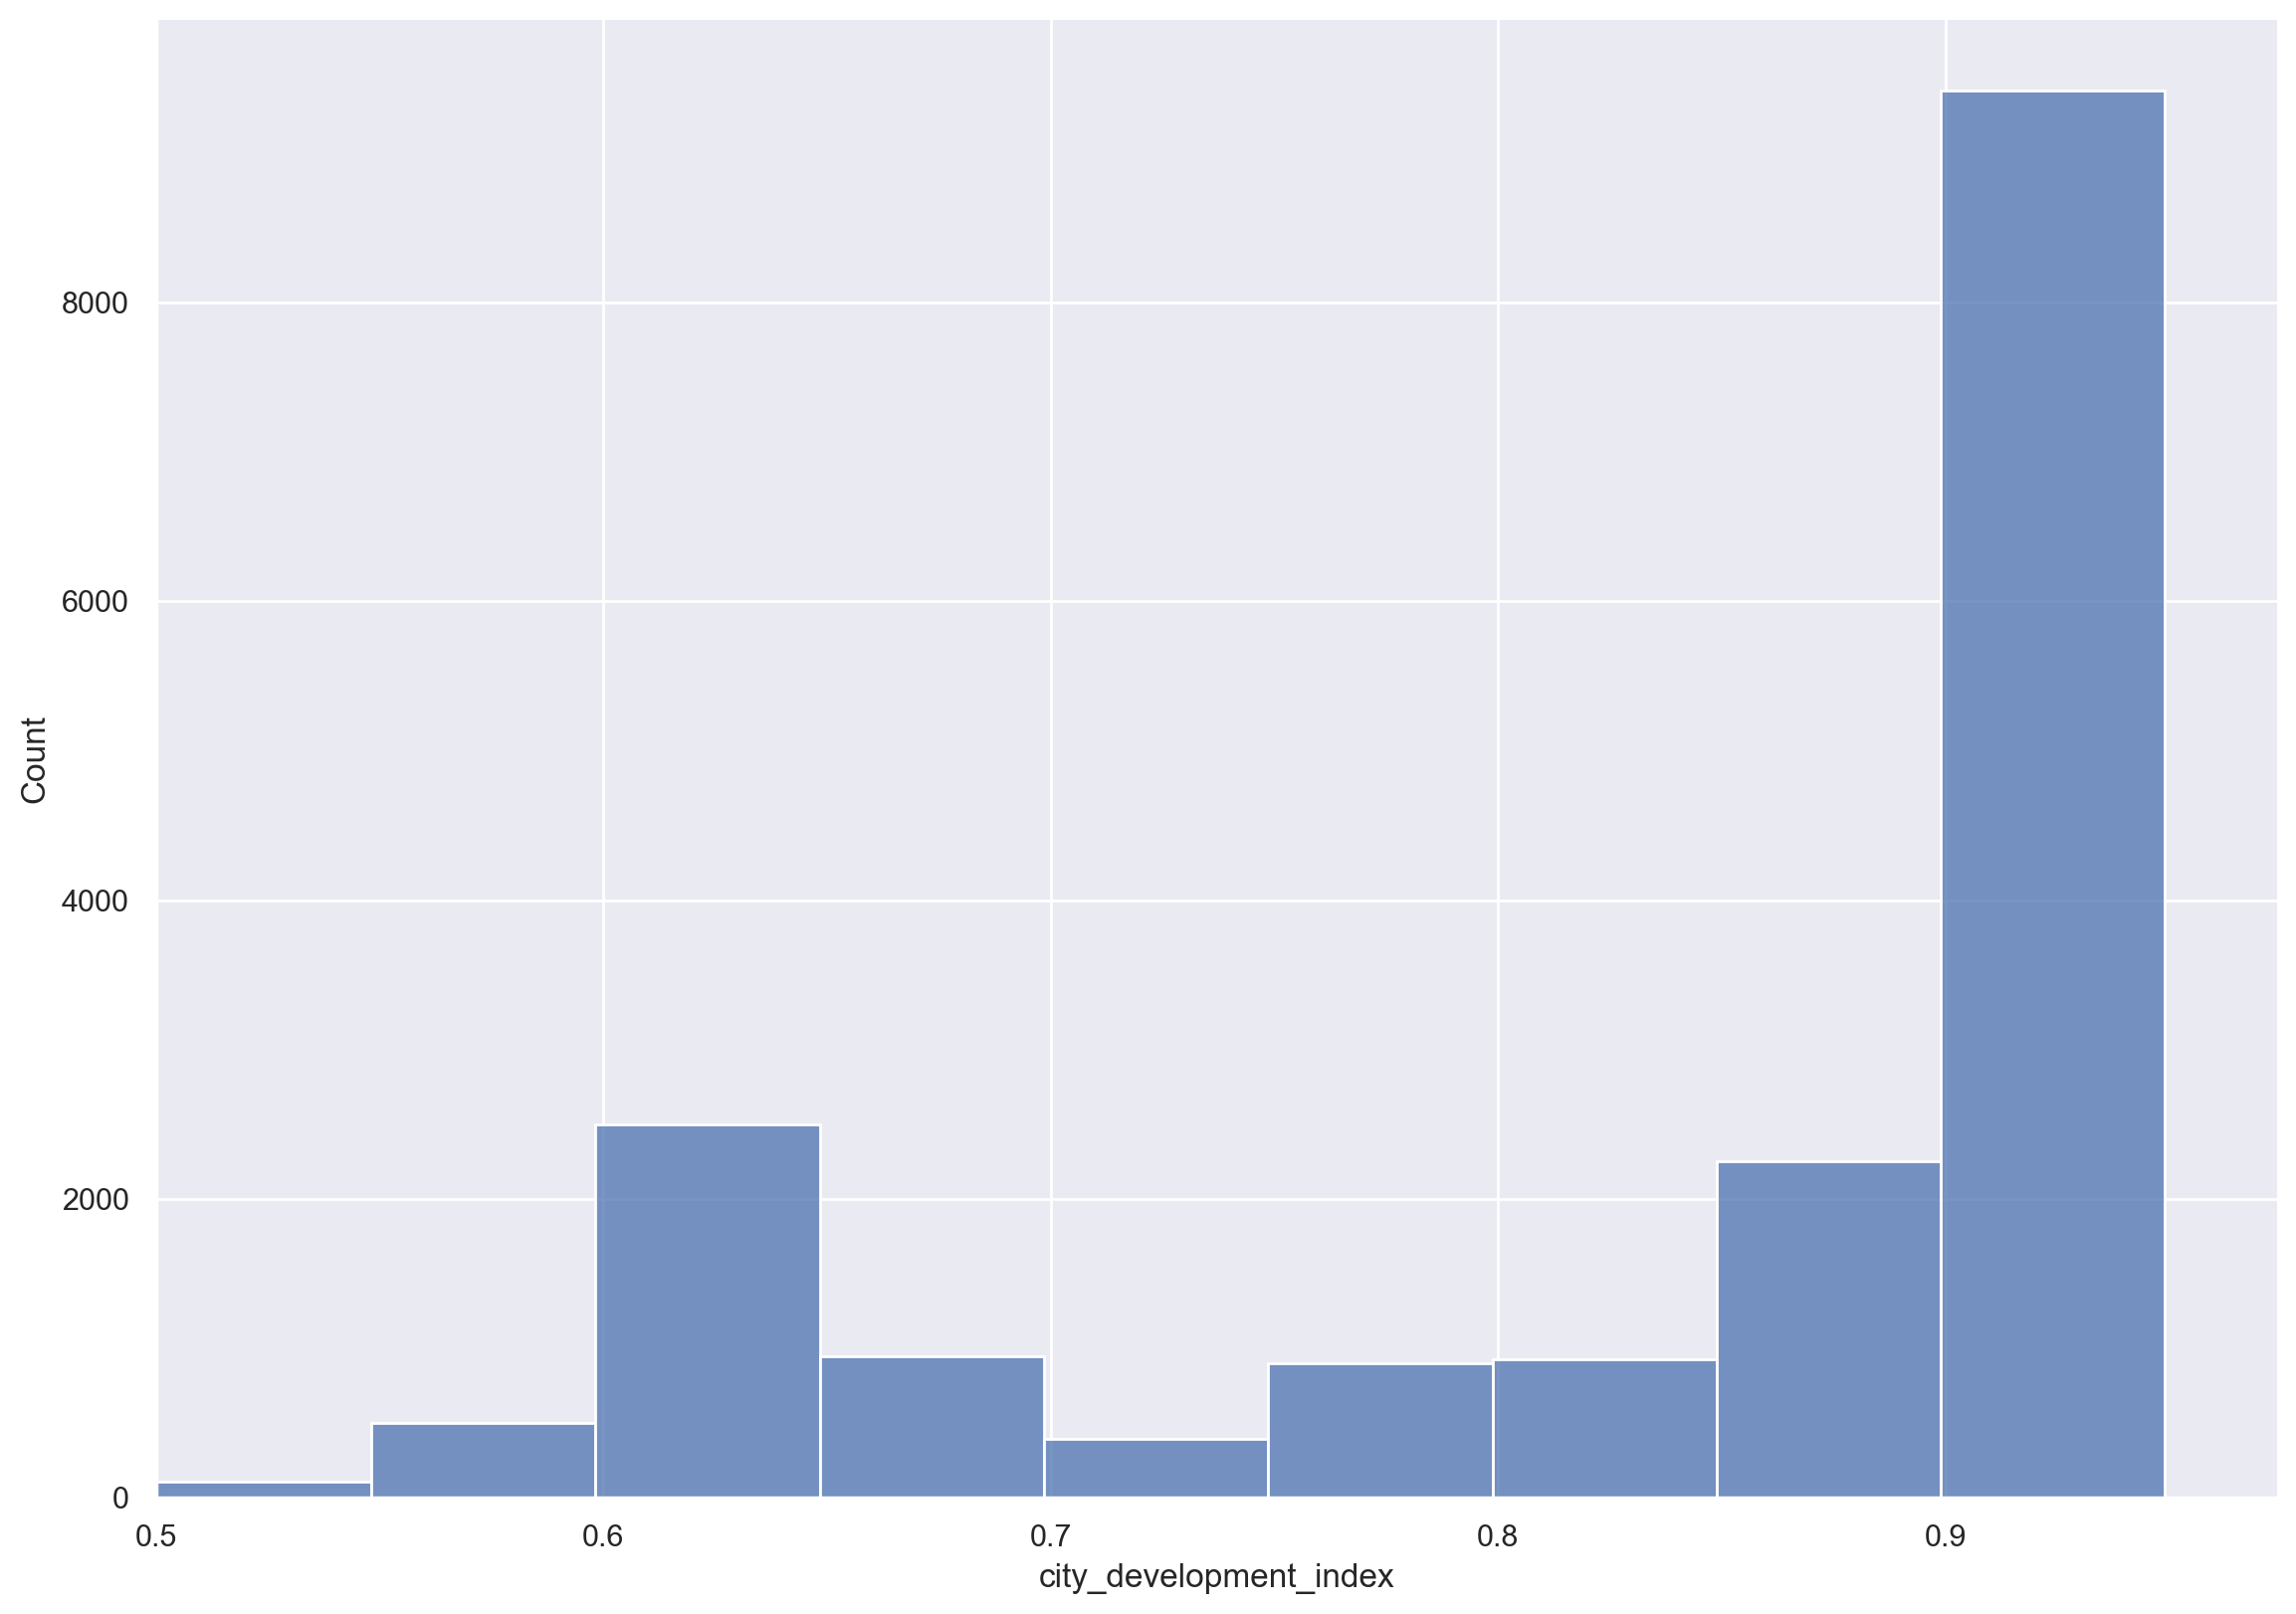

In [59]:
sns.displot(aug_train, x="city_development_index",height=8.27, aspect=11.7/8.27,bins=10).set(xlim=(0.5,None));

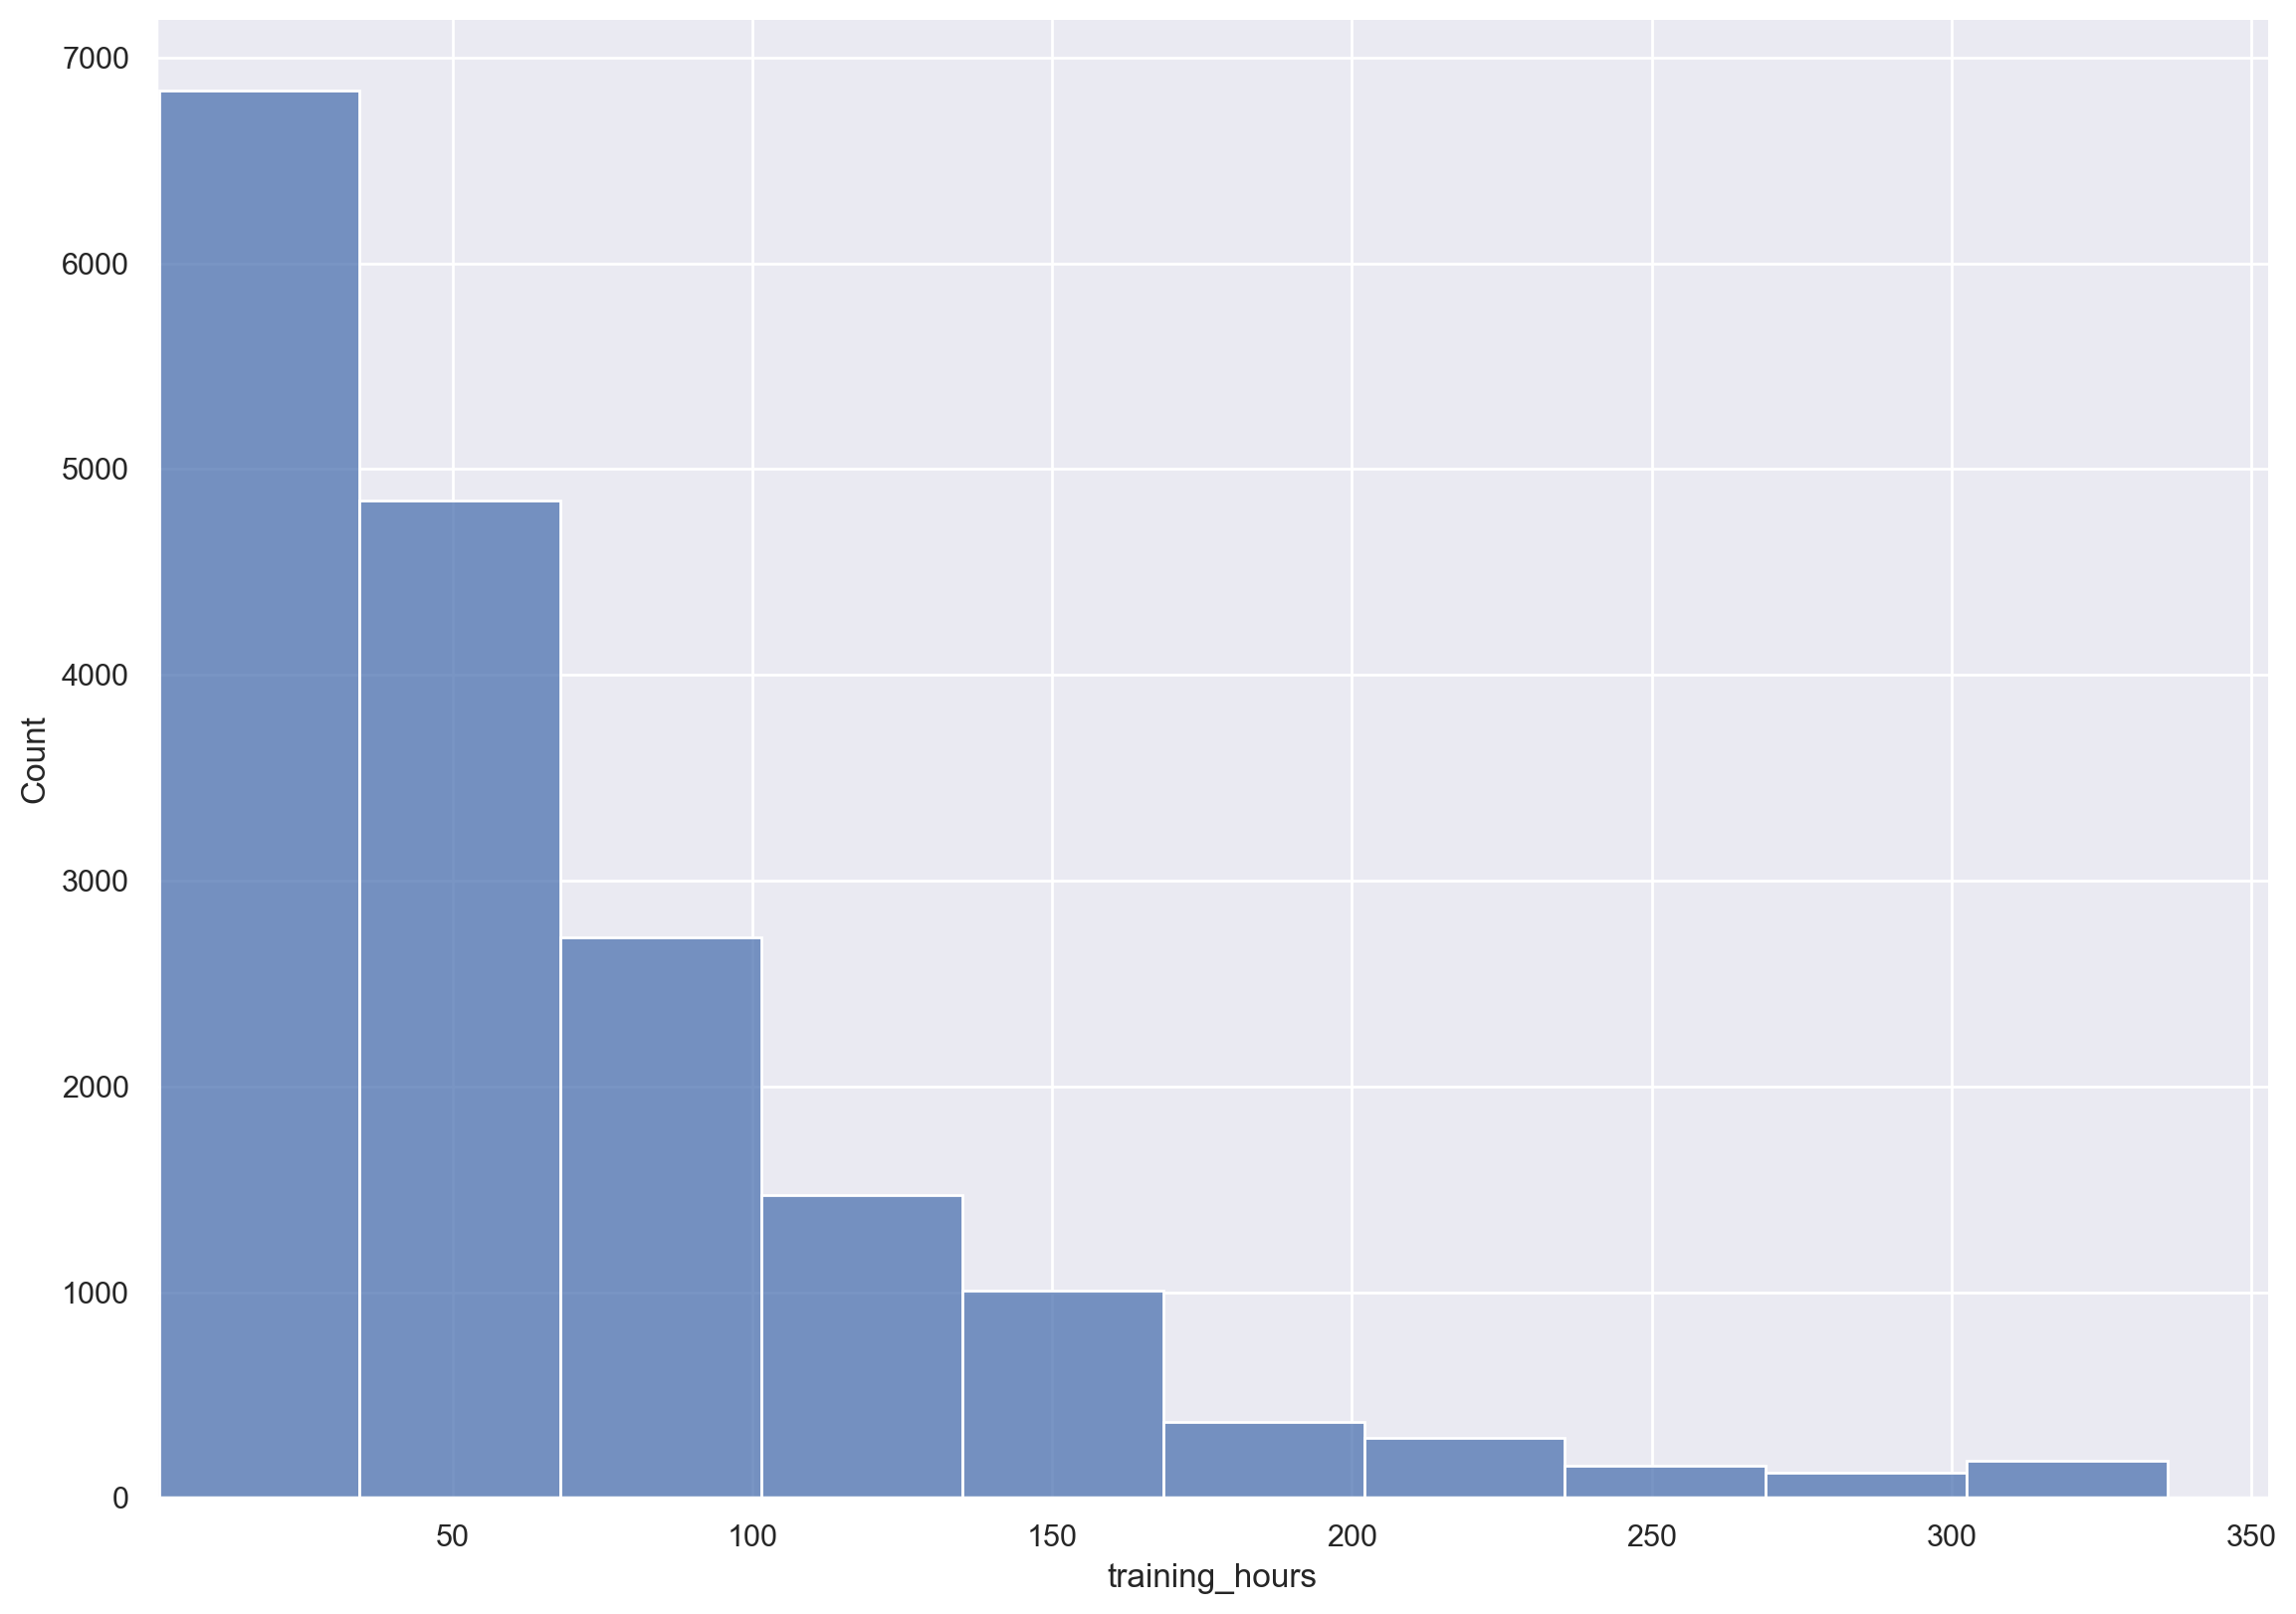

In [60]:
sns.displot(aug_train, x="training_hours",height=8.27, aspect=11.7/8.27,bins=10).set(xlim=(0.5,None));

# Predction Using Machine Learning Algorithms

In [62]:
ed_order = ['Primary School','High School','Graduate','Masters','Phd']
enroll_order = ['No Enrollment','Part time course','Full time course']
disc_order = ['STEM','Unknown','Humanities','Other','Business Degree','Arts','No Major']
exp_yrs_order = ['<1','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','>20']
exp_yrs_order_2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
size_order = ['0','<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
job_order = ['Never', '1', '2', '3', '4', '>4']
exp_order =['No relevant experience','Has relevant experience']
gender_order = ['Male','Female','Other','Not provided']

In [63]:
job_change = aug_train.groupby(['education_level','last_new_job'])['experience'].sum().unstack().loc[ed_order,job_order]
jc_never = job_change['Never']
job_change

job_change_norm = pd.crosstab(aug_train['education_level'],aug_train['last_new_job'],normalize='columns').loc[ed_order,job_order,]
job_change_norm = round(job_change_norm*100,1).astype(int)
job_change_norm



##
job_hunt_only = aug_train[aug_train['target']==1]
no_job_hunt_only = aug_train[aug_train['target']==0]


seekers_job_change_norm = pd.crosstab(job_hunt_only['education_level'],job_hunt_only['last_new_job'],normalize='columns').loc[ed_order,job_order,]
seekers_job_change_norm = round(seekers_job_change_norm*100,1).astype(int)
seekers_job_change_norm

non_seekers_job_change_norm = pd.crosstab(no_job_hunt_only['education_level'],no_job_hunt_only['last_new_job'],normalize='columns').loc[ed_order,job_order,]
non_seekers_job_change_norm = round(non_seekers_job_change_norm*100,1).astype(int)


In [66]:
 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.svm import LinearSVC


In [70]:
X = aug_train.dropna().drop(columns=['target']).values
y = aug_train.dropna()['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80)


# Classification with a linear SVM
svc = LinearSVC(dual=False, random_state=123)
params_grid = {"C": [10 ** k for k in range(-3, 4)]}
clf = GridSearchCV(svc, params_grid)
clf.fit(X_train, y_train)
print(
    "Accuracy on the test set with raw data: {:.3f}".format(clf.score(X_test, y_test))
)

print(clf.best_params_)


Accuracy on the test set with raw data: 0.784
{'C': 1}


In [71]:
X = aug_train.dropna().drop(columns=['target']).values
y = aug_train.dropna()['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80)


In [74]:
# Support Vector Machine 
pipeline = make_pipeline(StandardScaler(), SVC(kernel='sigmoid'))
pipeline.fit(X_train, y_train)
svc_prediction = pipeline.predict(X_test)
cm_svc = confusion_matrix(y_test, svc_prediction)
svc_df = pd.DataFrame(data=[accuracy_score(y_test, svc_prediction), recall_score(y_test, svc_prediction),
                   precision_score(y_test, svc_prediction), roc_auc_score(y_test, svc_prediction)], 
             columns=['SVC Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])


In [75]:
# Basic Decision Tree
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
dtree_prediction = dtree.predict(X_test)
cm_dtree = confusion_matrix(y_test, dtree_prediction)
dtree_df = pd.DataFrame(data=[accuracy_score(y_test, dtree_prediction), recall_score(y_test, dtree_prediction),
                   precision_score(y_test, dtree_prediction), roc_auc_score(y_test, dtree_prediction)], 
             columns=['Decision Tree Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])


In [76]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)
rfc_prediction = rfc.predict(X_test)
cm_rfc = confusion_matrix(y_test, rfc_prediction)
rfc_df = pd.DataFrame(data=[accuracy_score(y_test, rfc_prediction), recall_score(y_test, rfc_prediction),
                   precision_score(y_test, rfc_prediction), roc_auc_score(y_test, rfc_prediction)], 
             columns=['Random Forest Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])


In [100]:
    print(); print(cross_val_score(pipeline, X, y, scoring="accuracy", cv = 7))
    mean_score = cross_val_score(pipeline, X, y, scoring="accuracy", cv = 7).mean()
    print(mean_score)


[0.78632479 0.78632479 0.77505828 0.77885736 0.78157792 0.78002332
 0.79129421]
0.7827800950614786


In [93]:
    print(); print(cross_val_score(dtree, X, y, scoring="accuracy", cv = 7))
    mean_score = cross_val_score(dtree, X, y, scoring="accuracy", cv = 7).mean()
    print(mean_score)
    


[0.72804973 0.73232323 0.71989122 0.72949864 0.72405752 0.7193937
 0.7329965 ]
0.7256579409708053


In [99]:
    print(); print(cross_val_score(rfc, X, y, scoring="accuracy", cv = 7))
    mean_score = cross_val_score(rfc, X, y, scoring="accuracy", cv = 7).mean()
    print(mean_score)
    


[0.79448329 0.79254079 0.79098679 0.78468714 0.78585309 0.78274388
 0.7897396 ]
0.7882749888191009


# Conclusion: Random Forest is the most accurate Machine Learning algorithm used to predict data scientists who are looking for a job change, with accuracy = 0.7897396. 